### Arctic sea ice brightness temperatures using the DMSP F17/SSMIS sensor

* Dataset:  http://nsidc.org/data/NSIDC-0032/versions/2

* Satellites:  DMSP, DMSP 5D-2/F11, DMSP 5D-2/F13, DMSP 5D-2/F8, DMSP 5D-3/F17

* Sensors: [SSM/I](https://nsidc.org/data/docs/daac/ssmi_instrument.gd.html), [SSMIS](https://nsidc.org/data/docs/daac/ssmis_instrument)

### Datafiles

Sample filename (see http://nsidc.org/data/NSIDC-0032/versions/2#title5)

    EASE-F17-NL2014032A-V2.19V
    
Holds binary data in the original EASE map projection for the F17 dsatellite, northern hemisphere, low (25 km) resolution, Julian day 32 of 2014, ascending orbits, version 2, 19 GHz, vertically polarized

They are unsigned, 16 bit binary integers, stored in row-major order with shape 721 x 721

To get the brightness temperature in Kelvins, these need to be read in as integers then divided by 10.

### Map projection

The temperatures are projected onto an "ease original" grid, which is lambert equal area map using [epsg:3408](http://www.spatialreference.org/ref/epsg/nsidc-ease-grid-north/).  This grid assumes a spherical earth with a radius of 
6371228 meters.

Detailed description:  http://nsidc.org/data/ease

The "original ease" 25 km NL 721 x 721 array has a projected width and height that is given here:

http://nsidc.org/data/ease/gis.html#import-original-ease

See [NL.hdr](http://nsidc.org/data/gis/headers/NL.hdr) which gives the upper left (x,y) coordinates in meters as

(-9024309,9024309) for a coordinate system with (0,0) at its center.  This means that the Basemap plot
should have width=height = 2*9024309


In [1]:
%matplotlib inline
import glob
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from rasterio.transform import from_bounds
from pyresample import kd_tree,image, geometry
from e582lib.map_slices import make_xy
import pyproj
from pathlib import Path

### Reading in the data

0) use Path.glob to get all files starting with EASE

1) use [pathlib.Path](http://blog.danwin.com/using-python-3-pathlib-for-managing-filenames-and-directories/) to separate the file name and use as a dictionary key

2) skip the high resolutioin files (with NH in their name) and the time files (with TIM)

3) open the file as binary data and read in all bytes into a byte string

4) Construct a [bytearray](https://docs.python.org/3.5/library/functions.html?highlight=bytearray#bytearray) from the string, and use that to make a numpy array using np.from_buffer

5) Shape the array into 721 rows of 721 columns

6) Cast the ints to 32 bit floats and divide by 10 to get temperatures

7) Store the array in a dictinary keyed by file name

In [2]:
#
# we are in the notebooks folder
#
dirpath=Path('.')
#
# jump up one directory and look in the seaice_data folder
# to find all files starting with EASE
#
ease_files=dirpath.glob('../seaice_data/EASE*')
data_dict={}
for a_file in ease_files:
    #
    # in python 3.5, need to convert the Path object
    # in python 3.6, don't need to do this since open can
    # handle Path objects
    #
    with open(str(a_file),'rb') as infile:
        filestring=str(a_file)
        #
        # we don't want the high reolution or time data files
        #
        if filestring.find('NH') > -1:
            continue
        if filestring.find('TIM') > -1:
            continue
        #
        # separate out the filename to use as
        # a dictionary key
        #
        key=a_file.parts[-1]
        print('key is: {}'.format(key))
        the_bytes=infile.read()
        the_string=bytearray(the_bytes)
        the_array=np.frombuffer(the_string,dtype=np.uint16)
        the_array.shape=[721,721]
        the_array=the_array.astype(np.float32)
        the_array=the_array/10.
        data_dict[key]=the_array

key is: EASE-F17-NL2014032A-V2.19H
key is: EASE-F17-NL2014032A-V2.19V
key is: EASE-F17-NL2014032A-V2.22V
key is: EASE-F17-NL2014032A-V2.37H
key is: EASE-F17-NL2014032A-V2.37V
key is: EASE-F17-NL2014032A-V2.91H
key is: EASE-F17-NL2014032A-V2.91V
key is: EASE-F17-NL2014032D-V2.19H
key is: EASE-F17-NL2014032D-V2.19V
key is: EASE-F17-NL2014032D-V2.22V
key is: EASE-F17-NL2014032D-V2.37H
key is: EASE-F17-NL2014032D-V2.37V
key is: EASE-F17-NL2014032D-V2.91H
key is: EASE-F17-NL2014032D-V2.91V


### Mapping the data

There seems to be a bug in Basemap which prevents it from showing the full
domain.  I can get the domain fot 99.84% of full size before crashing.
For the first plot, cheat and shrink the map by this amount.  For subsequent plots,
use pyresample to resample onto a smaller domain.

### set the crs and the extent for pyresample and basemap

In [3]:
#http://nsidc.org/data/gis/headers/NL.hdr
cornerx=9024309  #meters, from NL.hdr
shrink=0.9984
cornery=cornerx
#basemap width, height should be 2*cornerx,2*cornery
orig_crs=dict(init='epsg:3408')
orig_extent=[-cornerx,-cornery,cornerx,cornery]

### Mask the missing data (0 values)

In [4]:
print(list(data_dict.keys()))

['EASE-F17-NL2014032A-V2.19H', 'EASE-F17-NL2014032A-V2.19V', 'EASE-F17-NL2014032A-V2.22V', 'EASE-F17-NL2014032A-V2.37H', 'EASE-F17-NL2014032A-V2.37V', 'EASE-F17-NL2014032A-V2.91H', 'EASE-F17-NL2014032A-V2.91V', 'EASE-F17-NL2014032D-V2.19H', 'EASE-F17-NL2014032D-V2.19V', 'EASE-F17-NL2014032D-V2.22V', 'EASE-F17-NL2014032D-V2.37H', 'EASE-F17-NL2014032D-V2.37V', 'EASE-F17-NL2014032D-V2.91H', 'EASE-F17-NL2014032D-V2.91V']


In [5]:
#
# get the first filename
#
file_name='EASE-F17-NL2014032A-V2.37H'
temps=data_dict[file_name]
#
# mask missing data, which is set to 0
#
masked_temps=np.ma.masked_where(temps < 50.,temps)
nrows,ncols=masked_temps.shape

### plot the whole array

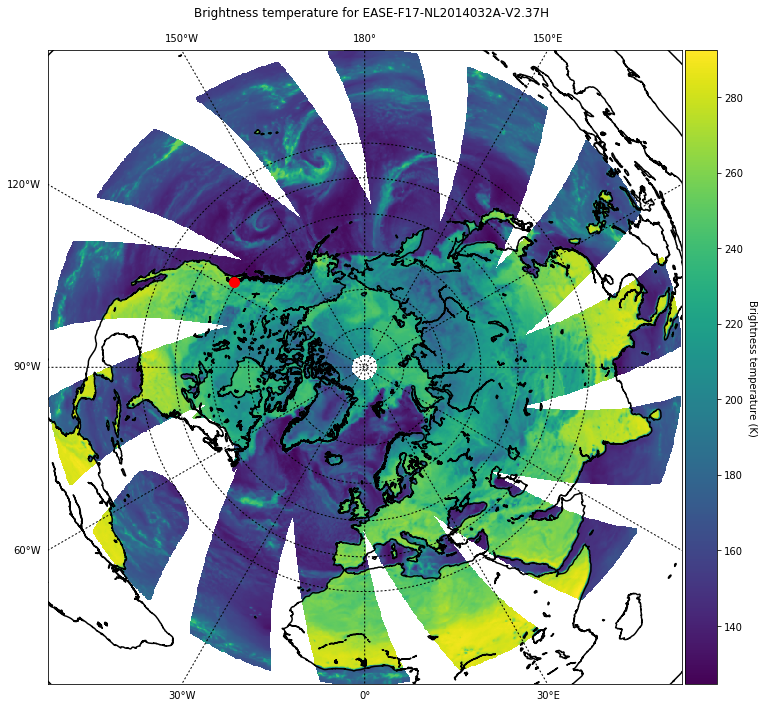

In [6]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
basemap_args=dict(epsg=3408,width=2*cornerx*shrink,height=2*cornerx*shrink,ax=ax,resolution='l')
bmap=Basemap(**basemap_args)

#
# get the transform so we can make x,y coords
#
orig_transform = from_bounds(bmap.llcrnrx,bmap.llcrnry,
                             bmap.urcrnrx,bmap.urcrnry,ncols,nrows)
xvals,yvals=make_xy(0,nrows,0,ncols,orig_transform)
CS=bmap.pcolormesh(xvals,yvals,masked_temps)
cax=bmap.colorbar(CS,'right',pad=0.05)
out=cax.ax.set_ylabel('Brightness temperature (K)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
#
# put vancouver on the map
#
van_lon,van_lat = [-123.1207,49.2827]
van_x,van_y=bmap(van_lon,van_lat)
bmap.plot(van_x,van_y,'ro',markersize=10,zorder=5)
#
# add coastlines and parallels
#
lat_sep,lon_sep= 10,30
parallels = np.arange(30, 90, lat_sep)
meridians = np.arange(-180, 180, lon_sep)
bmap.drawparallels(parallels, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=70)
bmap.drawmeridians(meridians, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=90)
bmap.drawcoastlines(linewidth=1.5, linestyle='solid', color='k',zorder=2)

fig.suptitle('Brightness temperature for {}'.format(file_name),y=0.92);

### Zoom and rotate the image

Try reducing the domain by half.  This will move the southern latitude line form 0 deg to 50 deg north and the central longitude line from 0 deg. to 90 deg W.

### Reduce the domain by half

In [7]:
newcornerx=cornerx/2.
newcornery=newcornerx
new_extent=[-newcornerx,-newcornerx,newcornerx,newcornerx]

### Change lat_0 to -90 deg

Also rotate the image so the central longitude is 90 deg W.  Since this is no longer epsg:3408, we
need to enter the other epsg:3408 parameters by hand instead of using the shortcut

In [8]:
radius=6371228
new_crs=dict(proj='laea',lat_0=90,lon_0= -90,a=radius,b=radius,units='m')
new_basemap_args=dict(projection='laea',lat_0=90,lon_0= -90,rsphere=(radius,radius))

### Check the domain by plotting a map without an image with the new boundaries

Note that I make a copy of new_basemap_args so I can use new_basemap_args as the template for other plots

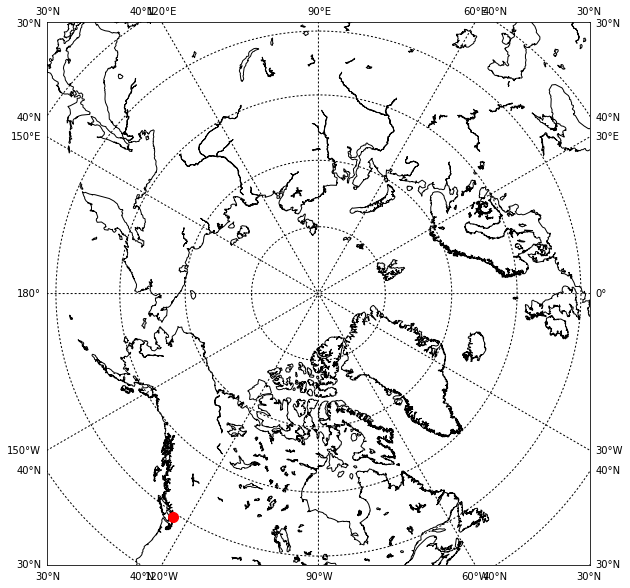

In [9]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
#
# make a copy so changes don't affect new_basemap_args
#
basemap_args=dict(new_basemap_args)
basemap_args.update(dict(width=2*newcornerx,height=2*newcornery,ax=ax,resolution='l'))
bmap_new=Basemap(**basemap_args)
bmap_new.drawcoastlines()
bmap_new.drawparallels(parallels, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=70)
bmap_new.drawmeridians(meridians, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=90)
van_x,van_y=bmap_new(van_lon,van_lat)
bmap_new.plot(van_x,van_y,'ro',markersize=10);

### now resample

This looks ok, so zoom to the new domain.  To keep the pixel resolution at about
25 km, make the new array 360 x 360.  Use an 18 km zone of influence for the neighbors.

In [10]:
newrows=360
newcols=newrows
orig_image = masked_temps
from_def = geometry.AreaDefinition('orig', 'orig image', 'area_orig',
                               orig_crs,
                               ncols, nrows,
                               orig_extent)
to_def = geometry.AreaDefinition('new', 'new image','area_new',
                               new_crs,
                               newcols,newrows,
                               new_extent)

from_nn = image.ImageContainerNearest(masked_temps,from_def, 
                                      radius_of_influence=18000,fill_value=None)
to_nn = from_nn.resample(to_def)
result_data_nn = to_nn.image_data        

### check the size of the remapped pixels

In [11]:
ll_x,ll_y,ur_x,ur_y=new_extent
pixel_size=(ur_x - ll_x)/newcols
print('approximate pixel size is: {:5.2f} km'.format(pixel_size*1.e-3))

approximate pixel size is: 25.07 km


### make the final plot

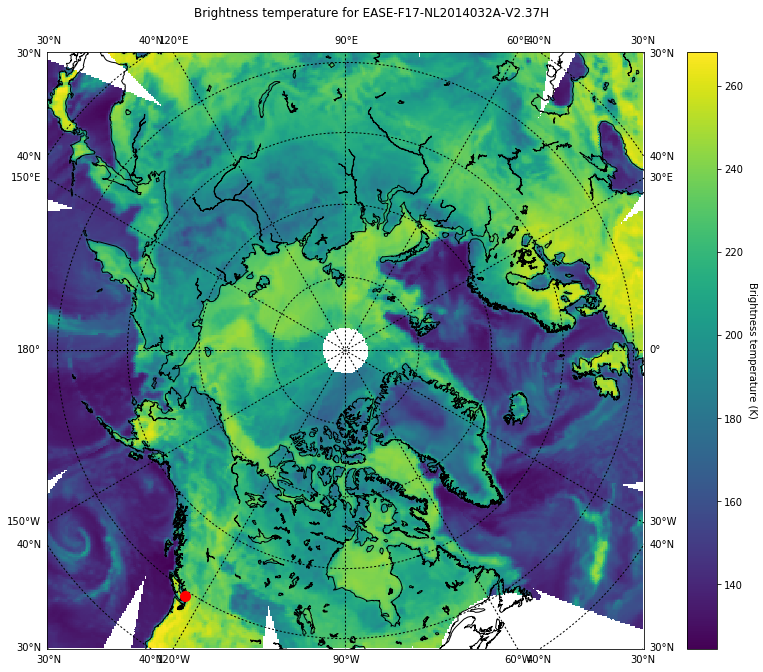

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,12))
basemap_args=dict(new_basemap_args)
basemap_args.update(dict(ax=ax,resolution='l',width=2*newcornerx,height=2*newcornery))
bmap=Basemap(**basemap_args)
#bmap.imshow(result_data_nn,origin='upper')
new_transform = from_bounds(bmap.llcrnrx,bmap.llcrnry,
                             bmap.urcrnrx,bmap.urcrnry,newcols,newrows)
xvals,yvals=make_xy(0,newrows,0,newcols,new_transform)
CS=bmap.pcolormesh(xvals,yvals,result_data_nn)
cax=bmap.colorbar(CS,'right',pad=0.6)
out=cax.ax.set_ylabel('Brightness temperature (K)')
out.set_rotation(270)
out.set_verticalalignment('bottom')
bmap.drawparallels(parallels, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=70)
bmap.drawmeridians(meridians, labels=[1, 1, 1, 1],
                       fontsize=10, latmax=90);
bmap.drawcoastlines()
van_x,van_y=bmap(van_lon,van_lat)
bmap.plot(van_x,van_y,'ro',markersize=10);
fig.suptitle('Brightness temperature for {}'.format(file_name),y=0.9);

In [13]:
bmap.projparams

{'a': 6371228,
 'b': 6371228,
 'lat_0': 90.0,
 'lon_0': -90.0,
 'proj': 'laea',
 'units': 'm',
 'x_0': 4512154.5,
 'y_0': 4512154.500000001}